In [1]:
using Random
# using BenchmarkTools
using PyPlot
using Distributions

using StatsFuns

In [2]:
init_α(K) = rand(Uniform(0, 100), K)
init_λ(a, b, K) = rand(Gamma(a, 1/b), K)
init_p(α) = rand(Dirichlet(α))

init_p (generic function with 1 method)

In [3]:
function sample_s(model, data)
    N = length(data)
    K = length(model.components)
    
    sₙ = Matrix{Int}(undef, N, K)
    η = Matrix{Float64}(undef, N, K)
    λ = [Distributions.params(comp)[1] for comp = model.components]
    p = probs(model)
    @inbounds for n = 1:N
        @simd for k = 1:K
            η[n, k] = data[n]*log(λ[k]) - λ[k] + log(p[k])
        end
        logsum_η = -logsumexp(η[n, :])
        @simd for k = 1:K
            η[n, k] = exp(η[n, k] + logsum_η)
        end
        sₙ[n, :] .= rand(Multinomial(1, η[n, :]))
    end
    sₙ
end

sample_s (generic function with 1 method)

In [4]:
function sample_λ(model, prior, sₙ, toy_data)
    K = size(sₙ, 2)
    λ = Vector{Float64}(undef, K)
    a = prior.a
    b = prior.b
    @inbounds for k = 1:K
        â = sum(sₙ[:, k] .* toy_data) + a
        b̂ = sum(sₙ[:, k]) + b
        λ[k] = rand(Gamma(â, 1/b̂))
    end
    λ
end

sample_λ (generic function with 1 method)

In [5]:
function sample_p(model, prior, sₙ)
    N, K = size(sₙ)
    α̂ = Vector{Float64}(undef, K)
    α = prior.α
    @inbounds for k = 1:K
        α̂[k] = sum(sₙ[:, k]) + α[k]
    end
    rand(Dirichlet(α̂))
end

sample_p (generic function with 1 method)

In [6]:
mutable struct PriorParameters
    a::Float64
    b::Float64
    α::AbstractVector
    PriorParameters() = new()
    PriorParameters(a, b, α) = new(a, b, α)
end

In [7]:
mutable struct PoissionMixtureModel
    model::MixtureModel{Univariate,Discrete,Poisson,Float64}
    λs::AbstractMatrix
    ps::AbstractMatrix
    loglikelihoods::AbstractVector
    PoissionMixtureModel() = new()
end

In [8]:
function init_model(;K::Int = 3, a = 1.0, b = 0.01)
    α = init_α(K)
    λ = init_λ(a, b, K)
    p = init_p(α)
    prior = PriorParameters(a, b, α)
    prior, MixtureModel(Poisson, λ, p)
end

function generate_toy_data(
        N::Int = 10^4;
        true_λ::AbstractVector = [100., 50., 15.],
        true_p::AbstractVector = [0.5, 0.2, 0.3]
    )
    true_data = MixtureModel(Poisson, true_λ, true_p)
    toy_data = rand(true_data, N)
    true_data, toy_data
end

generate_toy_data (generic function with 2 methods)

In [9]:
function gibbs!(
        pmm::PoissionMixtureModel,
        prior::PriorParameters,
        toy_data::AbstractVector;
        maxiter::Int = 2000
    )
    model = pmm.model
    N = length(toy_data)
    K = length(model.components)
    
    pmm.λs = Matrix{Float64}(undef, maxiter, K)
    pmm.ps = Matrix{Float64}(undef, maxiter, K)
    pmm.loglikelihoods = Vector{Float64}(undef, maxiter)
    
    for k = 1:K
        pmm.λs[1, k] = model.components[k].λ
        pmm.ps[1, k] = probs(model)[k]
    end
    pmm.loglikelihoods[1] = sum(logpdf.(model, toy_data))
    
    @inbounds @simd for i = 1:maxiter
    
        sₙ = sample_s(model, toy_data)
        λ = sample_λ(model, prior, sₙ, toy_data)
        p = sample_p(model, prior, sₙ)
        
        pmm.λs[i, :] .= λ
        pmm.ps[i, :] .= p
        model = MixtureModel(Poisson, λ, p)
        pmm.loglikelihoods[i] = sum(logpdf.(model, toy_data))
        pmm.model = model
        fill!(sₙ, 0)
    end
    pmm
end

gibbs! (generic function with 1 method)

In [10]:
a = 1.
b = 0.01
N = 2000
true_λ = [100., 50., 15.]
true_p = [0.5, 0.2, 0.3]
true_model, toy_data = generate_toy_data(N)
prior, model = init_model(a = a, b = b)

pmm = PoissionMixtureModel()
pmm.model = model

MixtureModel{Poisson}(K = 3)
components[1] (prior = 0.3340): Poisson{Float64}(λ=3.679805099583459)
components[2] (prior = 0.3749): Poisson{Float64}(λ=124.77259179737604)
components[3] (prior = 0.2911): Poisson{Float64}(λ=82.96622707982978)


In [11]:
gibbs!(pmm, prior, toy_data, maxiter=2000)

PoissionMixtureModel(MixtureModel{Poisson}(K = 3)
components[1] (prior = 0.2839): Poisson{Float64}(λ=15.124781971293839)
components[2] (prior = 0.4979): Poisson{Float64}(λ=101.15610637638858)
components[3] (prior = 0.2183): Poisson{Float64}(λ=50.311435079397185)
, [15.041080911343085 109.06213391573098 76.14662351505834; 15.800233724781577 103.86149856569014 66.49856393772842; … ; 15.195220529360768 100.52440776486411 49.6045983045834; 15.124781971293839 101.15610637638858 50.311435079397185], [0.2958081405181575 0.23653500382288675 0.4676568556589557; 0.29364622213228603 0.36290890888039046 0.3434448689873235; … ; 0.29137966003028903 0.5068536899378654 0.20176665003184546; 0.28387126413203256 0.497863311117827 0.21826542475014032], [-10927.336115492802, -9751.862195354353, -8879.377799952825, -8790.894334681501, -8790.216001189161, -8795.67753825341, -8793.43104728762, -8789.29687202301, -8791.17652319159, -8793.93193482715  …  -8792.590092870603, -8790.454832569776, -8797.63962538982

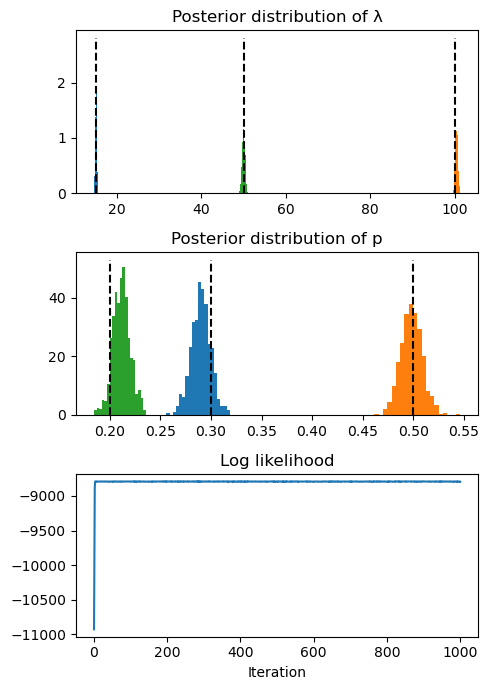

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(5, 7))
K = length(probs(pmm.model))
ax[1].set_title("Posterior distribution of λ")
for k = 1:K
    ax[1].hist(pmm.λs[1000:end, k], density=1, bins=20)
end
ax[1].vlines(true_λ, 0, ax[1].get_ylim()[2], color="k", linestyle="--")

ax[2].set_title("Posterior distribution of p")
for k = 1:K
    ax[2].hist(pmm.ps[1000:end, k], density=1, bins=20)
end
ax[2].vlines(true_p, 0, ax[2].get_ylim()[2], color="k", linestyle="--")

# ax[3].set_title("Log likelihood")
ax[3].set(title="Log likelihood", xlabel="Iteration")
ax[3].plot(1:1000, pmm.loglikelihoods[1:1000])

plt.tight_layout()

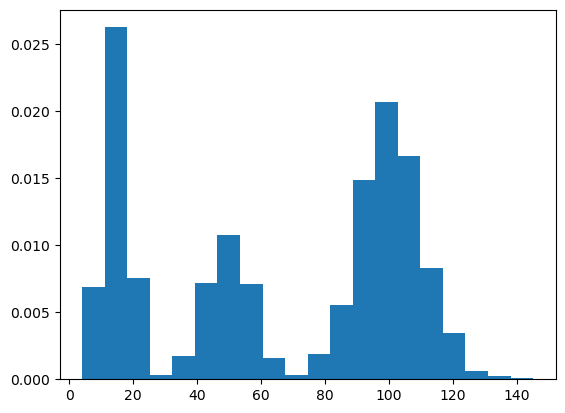

([0.006879432624113474, 0.026241134751773046, 0.007517730496453904, 0.0002836879432624112, 0.0017021276595744687, 0.00716312056737589, 0.010780141843971625, 0.007092198581560287, 0.0015602836879432646, 0.0003546099290780136, 0.0019148936170212774, 0.005531914893617024, 0.014822695035460999, 0.02063829787234039, 0.016666666666666673, 0.008297872340425535, 0.00347517730496454, 0.0006382978723404271, 0.00021276595744680818, 7.092198581560271e-5], [4.0, 11.05, 18.1, 25.15, 32.2, 39.25, 46.3, 53.35, 60.4, 67.44999999999999  …  81.55, 88.6, 95.64999999999999, 102.7, 109.75, 116.8, 123.85, 130.89999999999998, 137.95, 145.0], (PyObject <matplotlib.patches.Rectangle object at 0x0000000000EDE790>, PyObject <matplotlib.patches.Rectangle object at 0x0000000000EDE610>, PyObject <matplotlib.patches.Rectangle object at 0x0000000000EDEC70>, PyObject <matplotlib.patches.Rectangle object at 0x0000000000EDEF40>, PyObject <matplotlib.patches.Rectangle object at 0x0000000000EED250>, PyObject <matplotlib.pa

In [14]:
hist(toy_data, density=1, bins=20)